# Goal :
* Data Cleaning and EDA
* Develop a model to predict demand for shared bikes
* Find the Significant Variables for the model with appropriate metrics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set()
%matplotlib inline

# Functions

In [3]:
def label_subplots(pp):
  for ax in pp.axes.flat:
      ax.tick_params(axis='both', labelbottom=True)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [4]:
def get_vif(cols):
  df_vif = pd.DataFrame()
  df_vif['Features'] = cols
  df_vif['VIF'] = [VIF(X_train[cols].values, i) for i in range(len(cols))]
  df_vif['VIF'] = round(df_vif['VIF'],2)
  df_vif = df_vif.sort_values(by = "VIF", ascending = False)
  return df_vif

# Data Loading

In [5]:
!git clone "https://github.com/akshaysmin/Bike-Sharing-Demand-Prediction"

Cloning into 'Bike-Sharing-Demand-Prediction'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [6]:
path = '/content/Bike-Sharing-Demand-Prediction/shared bikes.csv'
df = pd.read_csv(path)

In [7]:
df_bikes = df.copy()

In [8]:
df_bikes.shape

(730, 16)

In [9]:
df_bikes.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [10]:
df_bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Data Cleaning

##Check for missing values

In [11]:
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


* We have no missing values
* All columns are of correct datatype

## Drop Unneccessary Columns

In [12]:
df_bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [13]:
df_bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [14]:
len(df_bikes['instant'].unique())

730

Conclusion : 
* instant represents unique id values for each row and can be dropped
* dteday can be dropped as we have day, year, month, etc. in other columns
* casual and registered can be dropped to avoid data leakage (casual + registered = cnt) as cnt is target variable
* temp and atemp shows very close values and need to be investigated

In [15]:
df_bikes.drop(['instant','dteday', 'casual', 'registered'], axis=1, inplace=True)
df_bikes.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [16]:
df[['temp', 'atemp']].corr()

,temp,atemp
temp,1.000000,0.991696
atemp,0.991696,1.000000


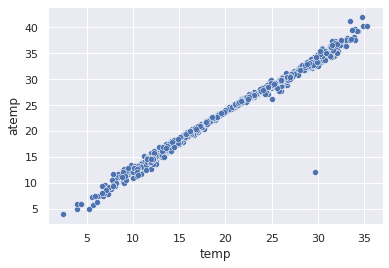

In [17]:
sns.scatterplot(data=df_bikes, x='temp', y='atemp')
plt.show()

* We will select only one of temp or atemp for model. Lets keep both for the time being.

Looking at Correlations

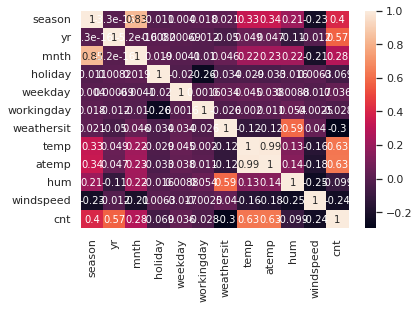

In [18]:
sns.heatmap(df_bikes.corr(), annot=True)
plt.show()

Conclusion:

For all columns except Count(which is target), we have very low correlation

## Renaming columns

In [19]:
df_bikes.rename(columns = {'season':'Season',
                           'yr':'Year',
                           'mnth':'Month',
                           'holiday':'Holiday',
                           'weekday':'Weekday',
                           'workingday':'Workingday',
                           'hum':'Humidity',
                           'windspeed': 'Windspeed',
                           'weathersit':'Weather',
                           'temp' : 'Temperature',
                           'atemp' : 'ATemperature',
                           'cnt':'Count'},
                inplace=True)
df_bikes.columns

Index(['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday',
       'Weather', 'Temperature', 'ATemperature', 'Humidity', 'Windspeed',
       'Count'],
      dtype='object')

##Handling Categorical Variables

Season, Year, Month, Holiday, Weekday, Workingday, Weather

In [ ]:
cat_cols = ['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weather']
num_cols = ['Temperature', 'Humidity', 'Windspeed', 'Count']

df_bikes[cat_cols] = df_bikes[cat_cols].astype('category')
df_bikes.info()

Year

In [ ]:
df_bikes['Year'].value_counts()

We will keep yr as it is because the years are not specified

Month

In [ ]:
df_bikes['Month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                         ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'),
                         inplace=True
                         )

Season

In [ ]:
df_bikes.groupby('Season')['Month'].value_counts()

In [ ]:
df_bikes['Season'].replace((1,2,3,4),
                           ('Spring', 'Summer', 'Autumn', 'Winter'),
                           inplace=True
                          )

Weather

In [ ]:
df_bikes['Weather'].value_counts()

In [ ]:
df_bikes['Weather'].replace((1,2,3),
                            ('Good/Clear', 'Moderate/Cloudy', 'Bad/Raining'),
                           inplace=True
                           )
df_bikes['Weather'].value_counts()

Holiday

In [ ]:
df_bikes['Holiday'].replace((0,1),
                            ('No', 'Yes'),
                            inplace=True
                            )
df_bikes['Holiday'].value_counts()

Weekday

In [ ]:
df_bikes['Weekday'].value_counts()

In [ ]:
df_bikes['Weekday'].replace((0,1,2,3,4,5,6),
                            ('Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'),
                            inplace=True
                            )
df_bikes['Weekday'].value_counts()

In [ ]:
df_bikes['Workingday'].replace((0,1),
                            ('No','Yes'),
                            inplace=True
                            )
df_bikes['Workingday'].value_counts()

## Remove Extreme Values

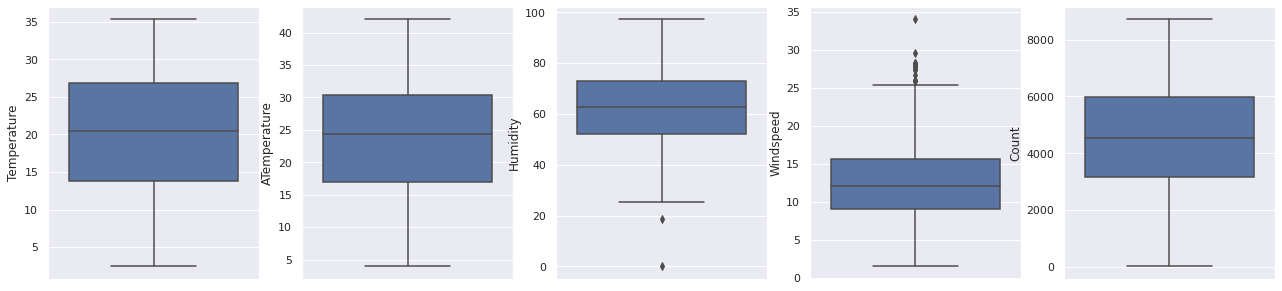

In [22]:
num_cols = ['Temperature', 'ATemperature',  'Humidity', 'Windspeed', 'Count']

fig, axis = plt.subplots(1,5, figsize=(22,5))
for i,col in enumerate(num_cols):
  sns.boxplot(data=df_bikes,
              y=col,
              ax=axis[i])
plt.show()

There doesn't seem to be very extreme values

# Exploratory Data Analysis

In [ ]:
df_bikes.head()

,Season,Year,Month,Holiday,Weekday,Workingday,Weather,Temperature,Humidity,Windspeed,Count
0,Spring,0,January,No,Monday,Yes,Moderate/Cloudy,14.110847,80.5833,10.749882,985
1,Spring,0,January,No,Tuesday,Yes,Moderate/Cloudy,14.902598,69.6087,16.652113,801
2,Spring,0,January,No,Wednesday,Yes,Good/Clear,8.050924,43.7273,16.636703,1349
3,Spring,0,January,No,Thursday,Yes,Good/Clear,8.200000,59.0435,10.739832,1562
4,Spring,0,January,No,Friday,Yes,Good/Clear,9.305237,43.6957,12.522300,1600


## Check Relationships using Pairplot

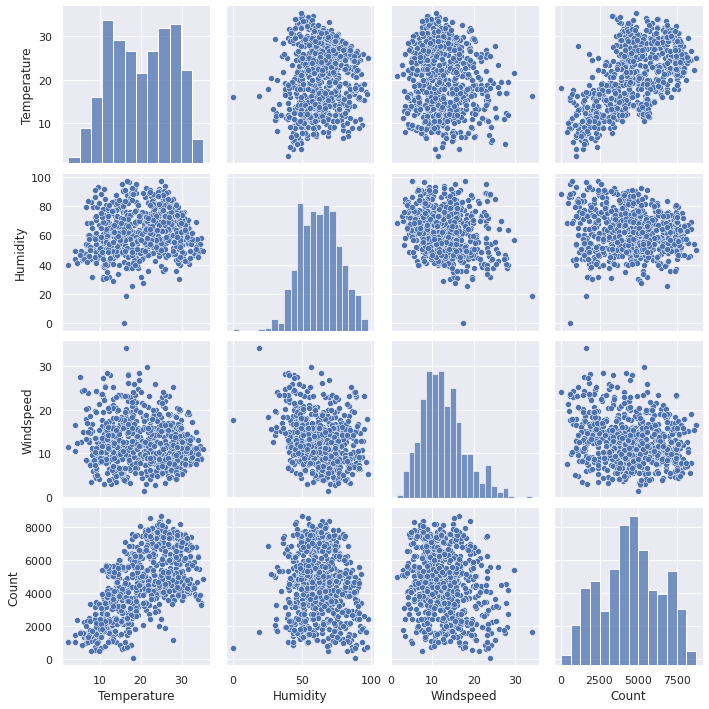

In [ ]:
sns.pairplot(df_bikes)
plt.show()

Conclusion:

* Temperature has the highest correlation with Count
* Demand is increasing with year

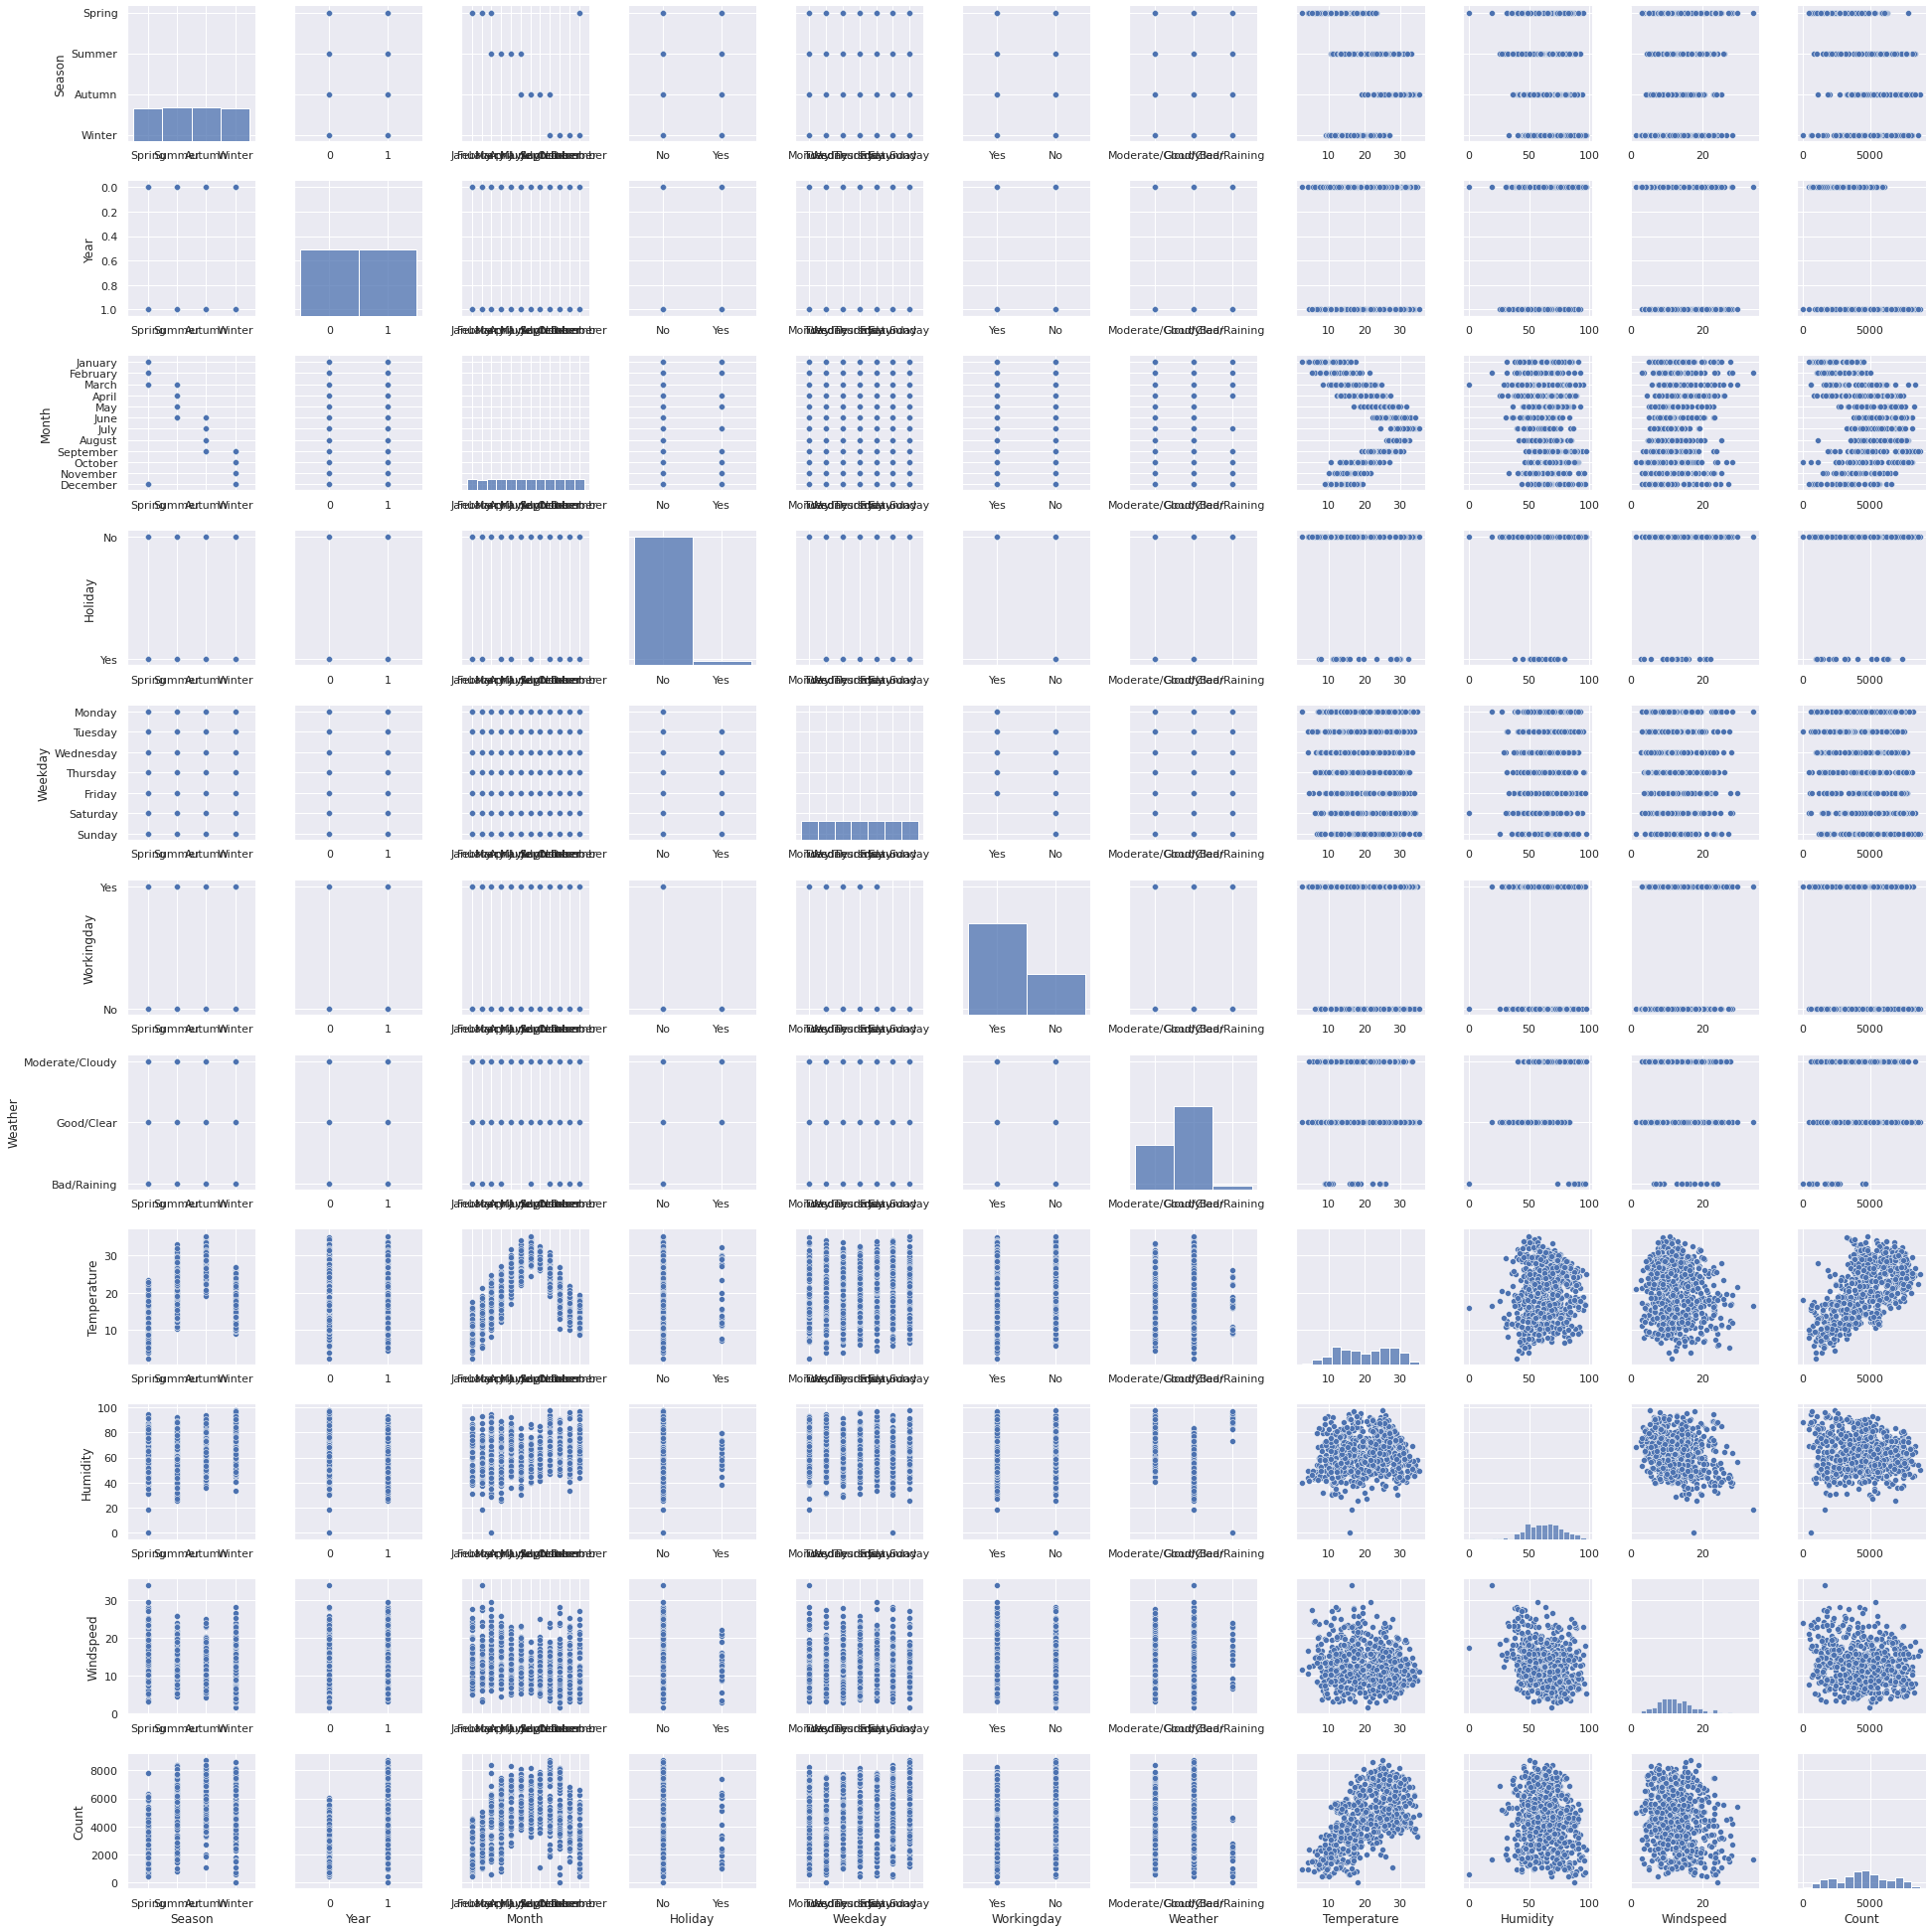

In [ ]:
pp = sns.pairplot(df_bikes, 
             vars=df_bikes.columns
             )
label_subplots(pp)

plt.show()

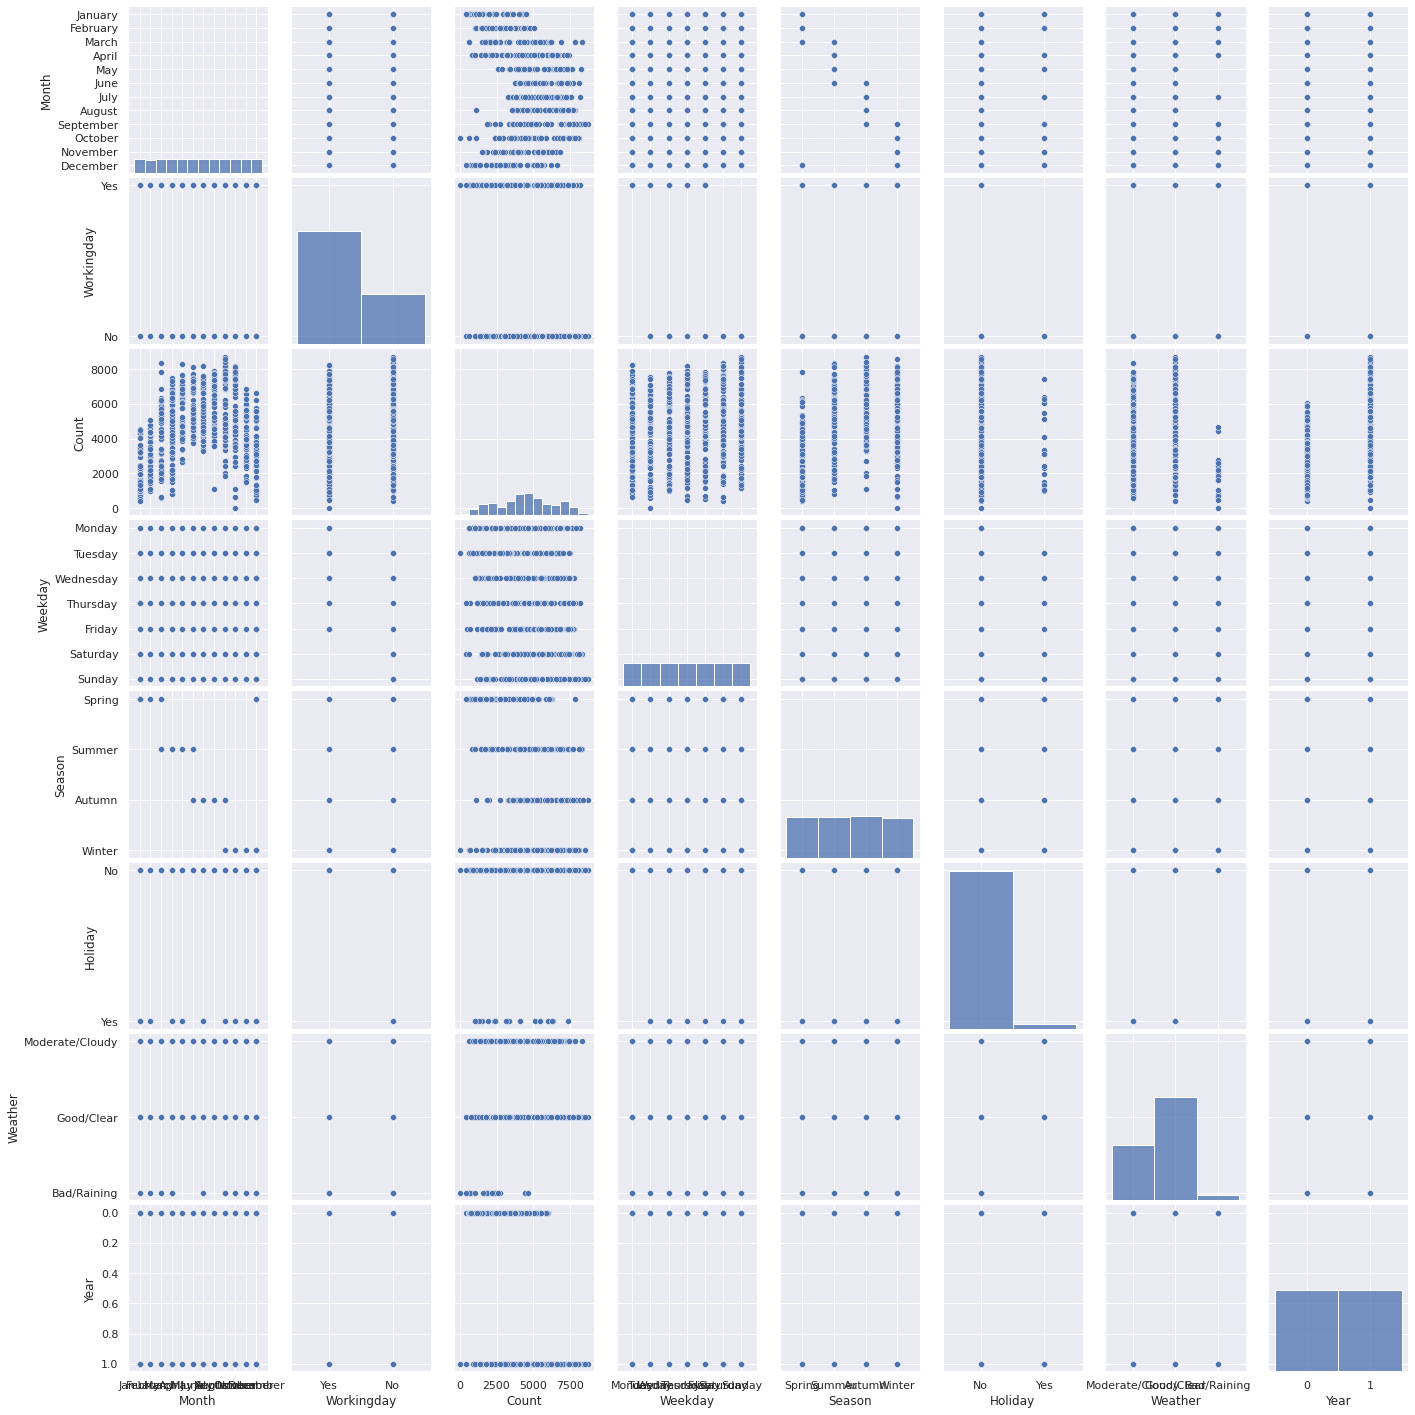

In [ ]:
pp = sns.pairplot(df_bikes, 
             vars=(set(df_bikes.columns)-set(num_cols))|{'Count'}
             )
# label_subplots(pp)
plt.show()

Conclusion:
* Most data is around moderate weather, bad weather has very low count
* Demand/Count is low for holiday
* Demand is increasing with year
* Demand and Temperature is parabola shaped with respect to months

## Count vs Categorical Variables

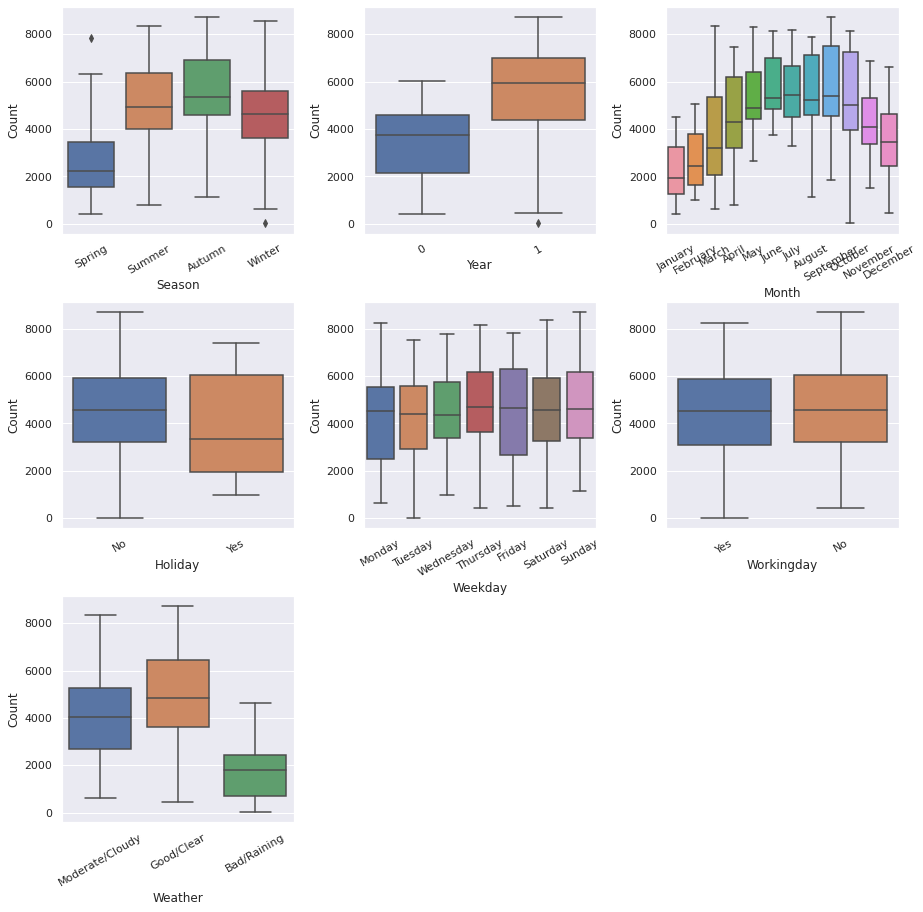

In [ ]:
cat_cols = ['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weather']

plt.figure(figsize=(15,15))
for i,col in enumerate(cat_cols):
    plt.subplot(3,3,i+1)
    ax = sns.boxplot(data=df_bikes,
                     x=col, 
                     y='Count',
                     order = None if col is not 'Month' else ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
                     )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Conclusions:
* People prefer biking in Clear Weather. Count is least in bad weather
* Spring has the least demand and Autumn has the hihgest
* Count increases with month till June and decreases after October
* Demand is slightly lo on Holiday
* Weekday and Workday doesn't seem to impact Demand in a clear way

## Count vs Numerical Variables

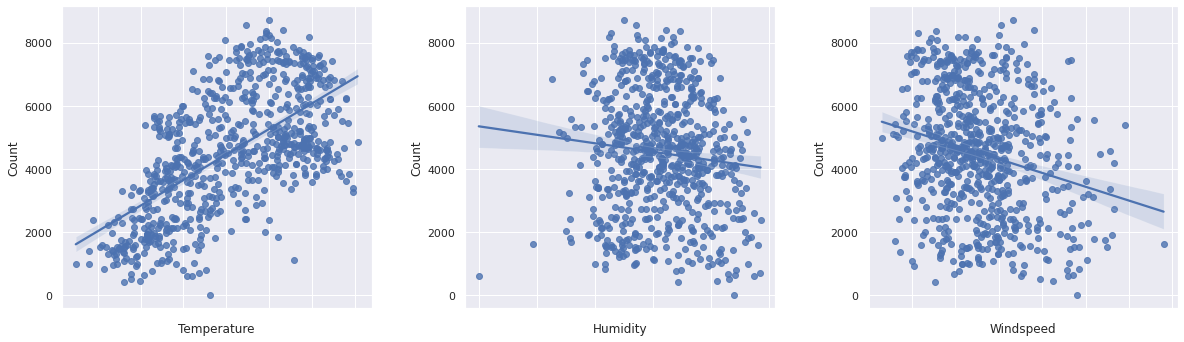

In [ ]:
num_cols = ['Temperature', 'Humidity', 'Windspeed']

plt.figure(figsize=(20,20))
for i,col in enumerate(num_cols):
    plt.subplot(3,3,i+1)
    ax = sns.regplot(data=df_bikes,
                     x=col, 
                     y='Count',
                     )
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

Conclusions:
* Temperature shows most correlation with Count/Demand
* Count is clearly increasing with increase in Temperature
* Humidity and Windspeed have more spread out values
* Humidity and Windspeed shows slightly negative correlation with Demand

# Model

## Data Preperation

In [23]:
cat_cols = ['Season', 'Year', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weather']
num_cols = ['Temperature', 'ATemperature', 'Humidity', 'Windspeed', 'Count']

dummy = pd.get_dummies(df_bikes[cat_cols])
df_model = pd.concat([df_bikes[num_cols],dummy], axis=1)
df_model.head()

,Temperature,ATemperature,Humidity,Windspeed,Count,Season,Year,Month,Holiday,Weekday,Workingday,Weather
0,14.110847,18.18125,80.5833,10.749882,985,1,0,1,0,1,1,2
1,14.902598,17.68695,69.6087,16.652113,801,1,0,1,0,2,1,2
2,8.050924,9.47025,43.7273,16.636703,1349,1,0,1,0,3,1,1
3,8.200000,10.60610,59.0435,10.739832,1562,1,0,1,0,4,1,1
4,9.305237,11.46350,43.6957,12.522300,1600,1,0,1,0,5,1,1


Train-Test Split

In [24]:
df_train, df_test = train_test_split(df_model, test_size=0.30, random_state=100)
df_train.shape, df_test.shape, type(df_train), type(df_test)

((511, 12),
 (219, 12),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

Scaling the data

In [25]:
num_cols = ['Temperature', 'ATemperature', 'Humidity', 'Windspeed', 'Count']

scaler = MinMaxScaler()
scaler.fit(df_train[num_cols])
df_train[num_cols] = scaler.transform(df_train[num_cols])

In [26]:
df_train.head()

,Temperature,ATemperature,Humidity,Windspeed,Count,Season,Year,Month,Holiday,Weekday,Workingday,Weather
653,0.509887,0.501133,0.575354,0.300794,0.864243,4,1,10,0,3,1,1
576,0.815169,0.766351,0.725633,0.264686,0.827658,3,1,7,0,3,1,1
426,0.442393,0.438975,0.640189,0.255342,0.465255,1,1,3,0,0,0,2
728,0.245101,0.200348,0.498067,0.663106,0.204096,1,1,12,0,1,1,1
482,0.395666,0.391735,0.504508,0.188475,0.482973,2,1,4,0,0,0,2


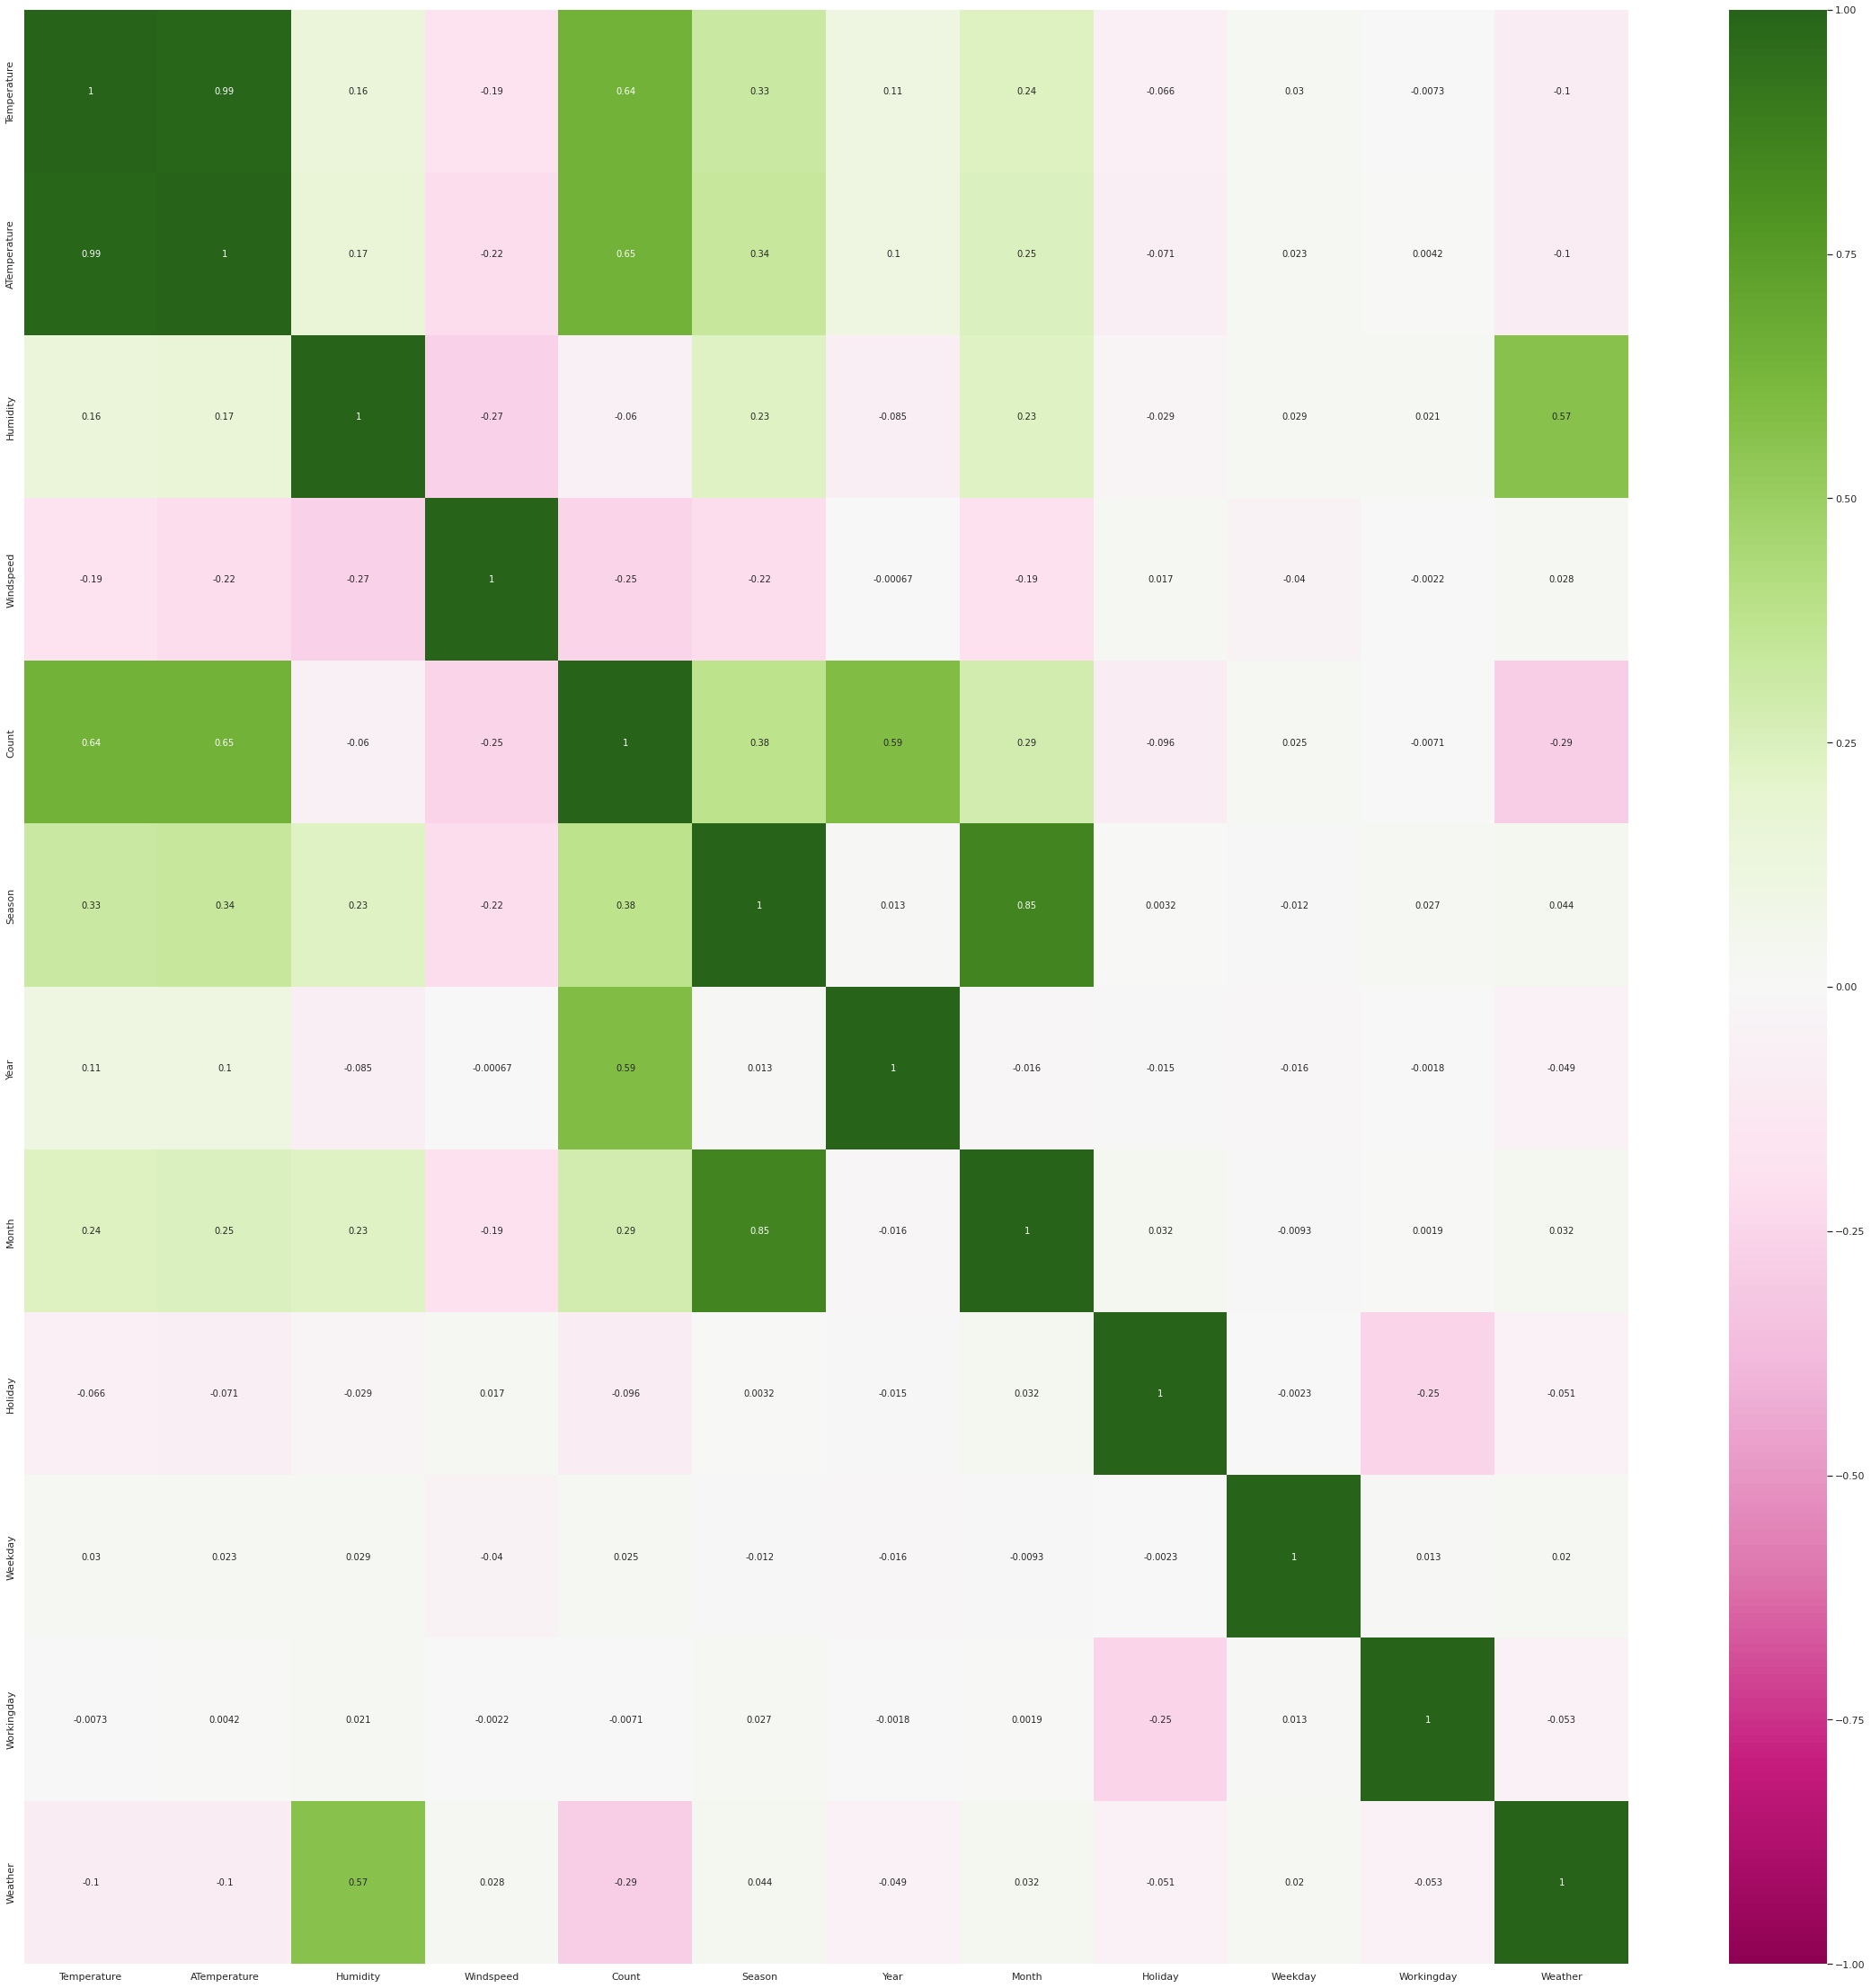

In [27]:
plt.figure(figsize=(40,40))
sns.heatmap(df_train.corr(), annot=True, cmap='PiYG', vmin=-1, vmax=1)
plt.show()

In [28]:
X_train = df_train.drop('Count', axis=1)
y_train = df_train['Count']
# X_train, y_train = X_train.values, y_train.values
y_train.shape, X_train.shape, type(X_train), type(y_train)

((511,), (511, 11), pandas.core.frame.DataFrame, pandas.core.series.Series)

In [29]:
X_test = df_test.drop('Count', axis=1)
y_test = df_test['Count']
# X_test, y_test = X_test.values, y_test.values
y_test.shape, X_test.shape, type(X_test), type(y_test)

((219,), (219, 11), pandas.core.frame.DataFrame, pandas.core.series.Series)

## Selecting Features with RFE

Using Linear Regression with RFE for feature selection

In [30]:
print('number of available features : ', X_train.shape[1])

number of available features :  11


In [31]:
lr = LinearRegression()
# lr.fit(X_train, y_train)

In [32]:
rfe = RFE(lr, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [33]:
X_train.iloc[:, 0]

653    0.509887
576    0.815169
426    0.442393
728    0.245101
482    0.395666
         ...   
578    0.863973
53     0.202618
350    0.248216
79     0.462664
520    0.600225
Name: Temperature, Length: 511, dtype: float64

In [34]:
print('Best 15 features selected by RFE')
rfe_cols = X_train.columns[rfe.support_]
print(*rfe_cols, sep='\n')

Best 15 features selected by RFE
Temperature
ATemperature
Humidity
Windspeed
Season
Year
Month
Holiday
Weekday
Workingday
Weather


In [35]:
sorted(list(zip(df_train.columns.drop('Count'), rfe.support_, rfe.ranking_)), key=lambda x : x[2])

[('Temperature', True, 1),
 ('ATemperature', True, 1),
 ('Humidity', True, 1),
 ('Windspeed', True, 1),
 ('Season', True, 1),
 ('Year', True, 1),
 ('Month', True, 1),
 ('Holiday', True, 1),
 ('Weekday', True, 1),
 ('Workingday', True, 1),
 ('Weather', True, 1)]

## Model

In [36]:
X_train[rfe_cols].head()

,Temperature,ATemperature,Humidity,Windspeed,Season,Year,Month,Holiday,Weekday,Workingday,Weather
653,0.509887,0.501133,0.575354,0.300794,4,1,10,0,3,1,1
576,0.815169,0.766351,0.725633,0.264686,3,1,7,0,3,1,1
426,0.442393,0.438975,0.640189,0.255342,1,1,3,0,0,0,2
728,0.245101,0.200348,0.498067,0.663106,1,1,12,0,1,1,1
482,0.395666,0.391735,0.504508,0.188475,2,1,4,0,0,0,2


In [37]:
X_train_lm1 = sm.add_constant(X_train[rfe_cols])

lm1 = sm.OLS(y_train, X_train_lm1).fit()
print(lm1.summary())

get_vif(rfe_cols)

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     181.5
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          1.82e-166
Time:                        17:30:00   Log-Likelihood:                 449.47
No. Observations:                 511   AIC:                            -874.9
Df Residuals:                     499   BIC:                            -824.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2626      0.030      8.757   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Features,VIF
1,ATemperature,348.64
0,Temperature,335.56
2,Humidity,26.63
4,Season,23.85
6,Month,17.10
10,Weather,12.62
3,Windspeed,3.84
9,Workingday,3.59
8,Weekday,3.10
5,Year,2.01


Lets Remove Year_0, Holiday_No, Weather_Bad/Raining due to high Variable Inflation factor to remove multicollinearity